In [381]:
import altair as alt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from functools import lru_cache
from dtaidistance import dtw, clustering

from pandas_profiling import ProfileReport

In [2]:
DIST_EPI = '../datasets/distribuicao_epi.csv'
DIST_RESPIRADORES = '../datasets/distribuicao_respiradores.csv'
DIST_ANESTESICOS = '../datasets/DistribuicaoAnestesicosBloqueadores.csv'
DIST_MEDICACAO = '../datasets/DistribuicaoCloroquinaOseltamivir.csv'
LEITO_OCUPACAO_DATASET = '../datasets/esus-vepi.LeitoOcupacao.csv'

# Carregando os Dados

## Registro de Ocupação Hospitalar COVID-19

In [3]:
df = pd.read_csv(LEITO_OCUPACAO_DATASET)
df

/Users/felipemfp/.local/share/virtualenvs/kdd-covid19-brazil-V6RyWlkX/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,_id,dataNotificacao,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,...,origem,_p_usuario,estadoNotificacao,municipioNotificacao,estado,municipio,excluido,validado,_created_at,_updated_at
0,p5Ez41Zu6B,2020-04-14T03:00:00.000Z,2303167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,aplicacao-web,_User$auVMjEVEVz,Santa Catarina,Itapema,Santa Catarina,Itapema,True,False,2020-04-15T13:44:30.085Z,2020-04-16T13:56:13.656Z
1,eUOMsSt7T7,2020-04-15T03:00:00.000Z,5935377\t,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,parse-cloud,_User$WBa5nfe9P9,Rio de Janeiro,Rio de Janeiro,Rio de Janeiro,Rio de Janeiro,False,False,2020-04-15T13:50:47.256Z,2020-08-01T20:08:13.116Z
2,QaG4oIBrMa,2020-04-15T14:57:16.255Z,0012599,15.0,1.0,3.0,2.0,0.0,0.0,0.0,...,parse-cloud,_User$6oxZQHBPQ7,Rio de Janeiro,Niterói,Rio de Janeiro,Niterói,False,False,2020-04-15T15:20:57.033Z,2020-08-01T20:02:12.729Z
3,ifya31F3ZF,2020-03-24T03:00:00.000Z,2562871,9.0,0.0,1.0,0.0,0.0,0.0,0.0,...,parse-cloud,_User$fhufIbmR9C,Ceará,Várzea Alegre,Ceará,Várzea Alegre,False,False,2020-04-15T16:58:32.839Z,2020-08-01T21:40:37.624Z
4,dkurDhelx9,2020-04-01T03:00:00.000Z,2252228,26.0,0.0,1.0,0.0,0.0,0.0,0.0,...,parse-cloud,_User$tkAdHTNhC9,Rio Grande do Sul,Encantado,Rio Grande do Sul,Encantado,False,False,2020-04-15T17:02:53.877Z,2020-08-01T21:37:53.664Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721533,ltERoH5v1O,2021-03-18T04:00:00.000Z,4001303,280.0,43.0,113.0,21.0,1.0,2.0,0.0,...,parse-cloud,_User$mswf4qQYhA,Rondônia,Porto Velho,Rondônia,Porto Velho,False,False,2021-03-22T00:47:27.412Z,2021-03-22T00:47:27.412Z
721534,wA6oTXVWDA,2021-03-19T04:00:00.000Z,4001303,265.0,47.0,114.0,21.0,0.0,3.0,0.0,...,parse-cloud,_User$mswf4qQYhA,Rondônia,Porto Velho,Rondônia,Porto Velho,False,False,2021-03-22T00:48:39.080Z,2021-03-22T00:48:39.080Z
721535,5Z0iIqYeDq,2021-03-20T04:00:00.000Z,4001303,272.0,48.0,111.0,21.0,0.0,2.0,1.0,...,parse-cloud,_User$mswf4qQYhA,Rondônia,Porto Velho,Rondônia,Porto Velho,False,False,2021-03-22T00:49:41.767Z,2021-03-22T00:49:41.767Z
721536,hG9yVDraIK,2021-02-24T03:00:00.000Z,5428,39.0,72.0,34.0,72.0,0.0,0.0,1.0,...,parse-cloud,_User$S4Y4yLGDnp,Bahia,Salvador,Bahia,Salvador,False,False,2021-03-22T00:54:27.791Z,2021-03-22T00:54:27.791Z


In [4]:
df = df[df['excluido'] == False]

In [7]:
ocupacao_df = df.copy()
ocupacao_df

,_id,dataNotificacao,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,...,origem,_p_usuario,estadoNotificacao,municipioNotificacao,estado,municipio,excluido,validado,_created_at,_updated_at
1,eUOMsSt7T7,2020-04-15T03:00:00.000Z,5935377\t,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,parse-cloud,_User$WBa5nfe9P9,Rio de Janeiro,Rio de Janeiro,Rio de Janeiro,Rio de Janeiro,False,False,2020-04-15T13:50:47.256Z,2020-08-01T20:08:13.116Z
2,QaG4oIBrMa,2020-04-15T14:57:16.255Z,0012599,15.0,1.0,3.0,2.0,0.0,0.0,0.0,...,parse-cloud,_User$6oxZQHBPQ7,Rio de Janeiro,Niterói,Rio de Janeiro,Niterói,False,False,2020-04-15T15:20:57.033Z,2020-08-01T20:02:12.729Z
3,ifya31F3ZF,2020-03-24T03:00:00.000Z,2562871,9.0,0.0,1.0,0.0,0.0,0.0,0.0,...,parse-cloud,_User$fhufIbmR9C,Ceará,Várzea Alegre,Ceará,Várzea Alegre,False,False,2020-04-15T16:58:32.839Z,2020-08-01T21:40:37.624Z
4,dkurDhelx9,2020-04-01T03:00:00.000Z,2252228,26.0,0.0,1.0,0.0,0.0,0.0,0.0,...,parse-cloud,_User$tkAdHTNhC9,Rio Grande do Sul,Encantado,Rio Grande do Sul,Encantado,False,False,2020-04-15T17:02:53.877Z,2020-08-01T21:37:53.664Z
5,yhrIosmBut,2020-04-02T03:00:00.000Z,2252228,25.0,0.0,0.0,0.0,0.0,1.0,0.0,...,parse-cloud,_User$tkAdHTNhC9,Rio Grande do Sul,Encantado,Rio Grande do Sul,Encantado,False,False,2020-04-15T17:05:56.421Z,2020-08-01T21:31:13.994Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721533,ltERoH5v1O,2021-03-18T04:00:00.000Z,4001303,280.0,43.0,113.0,21.0,1.0,2.0,0.0,...,parse-cloud,_User$mswf4qQYhA,Rondônia,Porto Velho,Rondônia,Porto Velho,False,False,2021-03-22T00:47:27.412Z,2021-03-22T00:47:27.412Z
721534,wA6oTXVWDA,2021-03-19T04:00:00.000Z,4001303,265.0,47.0,114.0,21.0,0.0,3.0,0.0,...,parse-cloud,_User$mswf4qQYhA,Rondônia,Porto Velho,Rondônia,Porto Velho,False,False,2021-03-22T00:48:39.080Z,2021-03-22T00:48:39.080Z
721535,5Z0iIqYeDq,2021-03-20T04:00:00.000Z,4001303,272.0,48.0,111.0,21.0,0.0,2.0,1.0,...,parse-cloud,_User$mswf4qQYhA,Rondônia,Porto Velho,Rondônia,Porto Velho,False,False,2021-03-22T00:49:41.767Z,2021-03-22T00:49:41.767Z
721536,hG9yVDraIK,2021-02-24T03:00:00.000Z,5428,39.0,72.0,34.0,72.0,0.0,0.0,1.0,...,parse-cloud,_User$S4Y4yLGDnp,Bahia,Salvador,Bahia,Salvador,False,False,2021-03-22T00:54:27.791Z,2021-03-22T00:54:27.791Z


## Distribuição de Anestésicos e Bloqueadores Musculares

In [8]:
df = pd.read_csv(DIST_ANESTESICOS, delimiter=';')

In [9]:
df = df[['REGIÃO', 'ESTADO', 'DESTINATÁRIO', 'ORIGEM', 'MEDICAMENTO',
       'APRESENTAÇÃO', 'QUANTIDADE', 'PEDIDO SISMAT', 'Pauta', 'STATUS',
       'DATA DE ENTREGA']]

In [10]:
df

,REGIÃO,ESTADO,DESTINATÁRIO,ORIGEM,MEDICAMENTO,APRESENTAÇÃO,QUANTIDADE,PEDIDO SISMAT,Pauta,STATUS,DATA DE ENTREGA
0,SUDESTE,SÃO PAULO,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,350.00,320424.0,1.0,Entrega realizada,29/06/2020
1,CENTRO-OESTE,MATO GROSSO,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,800.00,320423.0,1.0,Entrega realizada,29/06/2020
2,NORTE,AMAPA,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,2.20,320410.0,1.0,Entrega realizada,29/06/2020
3,NORDESTE,CEARÁ,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,16.00,320412.0,1.0,Entrega realizada,29/06/2020
4,NORDESTE,RIO GRANDE DO NORTE,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,450.00,320420.0,1.0,Entrega realizada,29/06/2020
...,...,...,...,...,...,...,...,...,...,...,...
601,NORTE,RORAIMA,SES,ORGANIZAÇÃO PAN-AMERICANA DA SAÚDE,"ROCURÔNIO, BROMETO 10 MG/ML",AMPOLA 5 mL,130.00,343345.0,27.0,Entrega realizada,02/03/2021
602,NORTE,TOCANTINS,SES,ORGANIZAÇÃO PAN-AMERICANA DA SAÚDE,"ROCURÔNIO, BROMETO 10 MG/ML",AMPOLA 5 mL,800.00,343346.0,27.0,Entrega realizada,02/03/2021
603,NORTE,AMAZONAS,SES,ORGANIZAÇÃO PAN-AMERICANA DA SAÚDE,"ROCURÔNIO, BROMETO 10 MG/ML",AMPOLA 5 mL,2.29,343202.0,27.0,Entrega realizada,01/03/2021
604,NORTE,SANTA CATARINA,SES,CONTRATO Nº 305/2020 - ARP 101/2020,"ATRACÚRIO, BESILATO 10MG/ML","AMPOLA 2,5 mL",21.30,343789.0,28.0,NaN,NaN


In [11]:
df['DATA DE ENTREGA'] = pd.to_datetime(df['DATA DE ENTREGA'],format='%d/%m/%Y')

In [13]:
anestesico_df = df.copy()
anestesico_df

,REGIÃO,ESTADO,DESTINATÁRIO,ORIGEM,MEDICAMENTO,APRESENTAÇÃO,QUANTIDADE,PEDIDO SISMAT,Pauta,STATUS,DATA DE ENTREGA
0,SUDESTE,SÃO PAULO,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,350.00,320424.0,1.0,Entrega realizada,2020-06-29
1,CENTRO-OESTE,MATO GROSSO,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,800.00,320423.0,1.0,Entrega realizada,2020-06-29
2,NORTE,AMAPA,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,2.20,320410.0,1.0,Entrega realizada,2020-06-29
3,NORDESTE,CEARÁ,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,16.00,320412.0,1.0,Entrega realizada,2020-06-29
4,NORDESTE,RIO GRANDE DO NORTE,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,450.00,320420.0,1.0,Entrega realizada,2020-06-29
...,...,...,...,...,...,...,...,...,...,...,...
601,NORTE,RORAIMA,SES,ORGANIZAÇÃO PAN-AMERICANA DA SAÚDE,"ROCURÔNIO, BROMETO 10 MG/ML",AMPOLA 5 mL,130.00,343345.0,27.0,Entrega realizada,2021-03-02
602,NORTE,TOCANTINS,SES,ORGANIZAÇÃO PAN-AMERICANA DA SAÚDE,"ROCURÔNIO, BROMETO 10 MG/ML",AMPOLA 5 mL,800.00,343346.0,27.0,Entrega realizada,2021-03-02
603,NORTE,AMAZONAS,SES,ORGANIZAÇÃO PAN-AMERICANA DA SAÚDE,"ROCURÔNIO, BROMETO 10 MG/ML",AMPOLA 5 mL,2.29,343202.0,27.0,Entrega realizada,2021-03-01
604,NORTE,SANTA CATARINA,SES,CONTRATO Nº 305/2020 - ARP 101/2020,"ATRACÚRIO, BESILATO 10MG/ML","AMPOLA 2,5 mL",21.30,343789.0,28.0,NaN,NaT


## Distribuição de Equipamentos de Proteção Individual e Insumos – Covid-19

In [14]:
df = pd.read_csv(DIST_EPI, delimiter=';')

In [15]:
df

,Material,Dt.Saída,Nº Pedido,Requisitante / Destino,Unidade,Quantidade,Status
0,Álcool,19/03/2020,308748,Acre,Litro,"9,6",Entregue
1,Álcool,19/03/2020,308748,Acre,Litro,42,Entregue
2,Álcool,19/03/2020,308499,Acre,Litro,12,Entregue
3,Álcool,19/03/2020,308500,Acre,Litro,12,Entregue
4,Álcool,25/03/2020,309483,Acre,Litro,48,Entregue
...,...,...,...,...,...,...,...
6959,Teste Rápido,01/12/2020,666666,Outros Órgãos Federais,Teste,1000,Entregue
6960,Teste Rápido,01/12/2020,666666,São Paulo,Teste,5000,Entregue
6961,Teste Rápido,23/12/2020,666666,Pará,Teste,3000,Entregue
6962,Teste Rápido,23/12/2020,666666,Outros Órgãos Federais,Teste,25000,Entregue


In [16]:
df['Dt.Saída'] = pd.to_datetime(df['Dt.Saída'], format='%d/%m/%Y')

In [18]:
epi_df = df.copy()
epi_df

,Material,Dt.Saída,Nº Pedido,Requisitante / Destino,Unidade,Quantidade,Status
0,Álcool,2020-03-19,308748,Acre,Litro,"9,6",Entregue
1,Álcool,2020-03-19,308748,Acre,Litro,42,Entregue
2,Álcool,2020-03-19,308499,Acre,Litro,12,Entregue
3,Álcool,2020-03-19,308500,Acre,Litro,12,Entregue
4,Álcool,2020-03-25,309483,Acre,Litro,48,Entregue
...,...,...,...,...,...,...,...
6959,Teste Rápido,2020-12-01,666666,Outros Órgãos Federais,Teste,1000,Entregue
6960,Teste Rápido,2020-12-01,666666,São Paulo,Teste,5000,Entregue
6961,Teste Rápido,2020-12-23,666666,Pará,Teste,3000,Entregue
6962,Teste Rápido,2020-12-23,666666,Outros Órgãos Federais,Teste,25000,Entregue


## Distribuição de Respiradores

In [19]:
df = pd.read_csv(DIST_RESPIRADORES, delimiter=';')

In [20]:
df

,DATA,FORNECEDOR,DESTINO,ESTADO/MUNICIPIO,TIPO,QUANTIDADE,VALOR,DESTINATARIO,UF,DATA DE ENTREGA
0,21/05/2020,VYAIRE,ACRE,ESTADO,UTI,20.0,"1200000,00",Secretaria Estadual de Saúde,AC,23/05/2020
1,21/05/2020,MAGNAMED,ACRE,ESTADO,TRANSPORTE,10.0,"482900,00",Secretaria Estadual de Saúde,AC,23/05/2020
2,05/06/2020,LEISTUNG,ACRE,ESTADO,UTI,30.0,"1800000,00",Secretaria Estadual de Saúde,AC,08/06/2020
3,16/06/2020,VYAIRE,ACRE,MUNICIPIO,UTI,5.0,"300000,00",Secretaria Municipal de Saúde (Sena Madureira),AC,24/06/2020
4,16/06/2020,MAGNAMED,ACRE,MUNICIPIO,TRANSPORTE,5.0,"241450,00",Secretaria Municipal de Saúde (Sena Madureira),AC,24/06/2020
...,...,...,...,...,...,...,...,...,...,...
2094,07/08/2020,MAGNAMED,LIBANO,-,TRANSPORTE,300.0,"14487000,00",MISSÃO FAB (Doação Destino ao Libano).,-,08/08/2020
2095,29/12/2020,MAGNAMED,PERU,-,UTI,100.0,"6000000,00",Cooperação Humanitária (Peru),-,28/12/2020
2096,29/12/2020,KTK,PERU,-,TRANSPORTE,230.0,"4600000,00",Cooperação Humanitária (Peru),-,28/12/2020
2097,08/01/2021,KTK,HAITI,-,TRANSPORTE,50.0,"1000000,00",Cooperação Humanitária (HAITI),-,12/01/2021


In [21]:
df = df[df['UF'].str.len() == 2].copy()

In [22]:
df

,DATA,FORNECEDOR,DESTINO,ESTADO/MUNICIPIO,TIPO,QUANTIDADE,VALOR,DESTINATARIO,UF,DATA DE ENTREGA
0,21/05/2020,VYAIRE,ACRE,ESTADO,UTI,20.0,"1200000,00",Secretaria Estadual de Saúde,AC,23/05/2020
1,21/05/2020,MAGNAMED,ACRE,ESTADO,TRANSPORTE,10.0,"482900,00",Secretaria Estadual de Saúde,AC,23/05/2020
2,05/06/2020,LEISTUNG,ACRE,ESTADO,UTI,30.0,"1800000,00",Secretaria Estadual de Saúde,AC,08/06/2020
3,16/06/2020,VYAIRE,ACRE,MUNICIPIO,UTI,5.0,"300000,00",Secretaria Municipal de Saúde (Sena Madureira),AC,24/06/2020
4,16/06/2020,MAGNAMED,ACRE,MUNICIPIO,TRANSPORTE,5.0,"241450,00",Secretaria Municipal de Saúde (Sena Madureira),AC,24/06/2020
...,...,...,...,...,...,...,...,...,...,...
2089,26/10/2020,KTK,TOCANTINS,MUNICIPIO,TRANSPORTE,2.0,"40000,00",SMS de Silvanopolis,TO,05/11/2020
2090,26/10/2020,KTK,TOCANTINS,MUNICIPIO,TRANSPORTE,2.0,"40000,00",SMS de Monte do Carmo,TO,04/11/2020
2091,08/12/2020,KTK,TOCANTINS,MUNICIPIO,TRANSPORTE,1.0,"20000,00",SMS de ARAGUAINA,TO,15/12/2020
2092,08/12/2020,LEISTUNG,TOCANTINS,MUNICIPIO,UTI,2.0,"120000,00",SMS de ARAGUAINA,TO,15/12/2020


In [23]:
df['ENTREGA'] = pd.to_datetime(df['DATA DE ENTREGA'], format='%d/%m/%Y', errors='coerce')

In [24]:
df = df[df['ENTREGA'].notnull()].copy()

In [25]:
df

,DATA,FORNECEDOR,DESTINO,ESTADO/MUNICIPIO,TIPO,QUANTIDADE,VALOR,DESTINATARIO,UF,DATA DE ENTREGA,ENTREGA
0,21/05/2020,VYAIRE,ACRE,ESTADO,UTI,20.0,"1200000,00",Secretaria Estadual de Saúde,AC,23/05/2020,2020-05-23
1,21/05/2020,MAGNAMED,ACRE,ESTADO,TRANSPORTE,10.0,"482900,00",Secretaria Estadual de Saúde,AC,23/05/2020,2020-05-23
2,05/06/2020,LEISTUNG,ACRE,ESTADO,UTI,30.0,"1800000,00",Secretaria Estadual de Saúde,AC,08/06/2020,2020-06-08
3,16/06/2020,VYAIRE,ACRE,MUNICIPIO,UTI,5.0,"300000,00",Secretaria Municipal de Saúde (Sena Madureira),AC,24/06/2020,2020-06-24
4,16/06/2020,MAGNAMED,ACRE,MUNICIPIO,TRANSPORTE,5.0,"241450,00",Secretaria Municipal de Saúde (Sena Madureira),AC,24/06/2020,2020-06-24
...,...,...,...,...,...,...,...,...,...,...,...
2089,26/10/2020,KTK,TOCANTINS,MUNICIPIO,TRANSPORTE,2.0,"40000,00",SMS de Silvanopolis,TO,05/11/2020,2020-11-05
2090,26/10/2020,KTK,TOCANTINS,MUNICIPIO,TRANSPORTE,2.0,"40000,00",SMS de Monte do Carmo,TO,04/11/2020,2020-11-04
2091,08/12/2020,KTK,TOCANTINS,MUNICIPIO,TRANSPORTE,1.0,"20000,00",SMS de ARAGUAINA,TO,15/12/2020,2020-12-15
2092,08/12/2020,LEISTUNG,TOCANTINS,MUNICIPIO,UTI,2.0,"120000,00",SMS de ARAGUAINA,TO,15/12/2020,2020-12-15


In [26]:
df['VALOR'] = df['VALOR'].str.replace(',', '.').astype(float)

In [27]:
df

,DATA,FORNECEDOR,DESTINO,ESTADO/MUNICIPIO,TIPO,QUANTIDADE,VALOR,DESTINATARIO,UF,DATA DE ENTREGA,ENTREGA
0,21/05/2020,VYAIRE,ACRE,ESTADO,UTI,20.0,1200000.0,Secretaria Estadual de Saúde,AC,23/05/2020,2020-05-23
1,21/05/2020,MAGNAMED,ACRE,ESTADO,TRANSPORTE,10.0,482900.0,Secretaria Estadual de Saúde,AC,23/05/2020,2020-05-23
2,05/06/2020,LEISTUNG,ACRE,ESTADO,UTI,30.0,1800000.0,Secretaria Estadual de Saúde,AC,08/06/2020,2020-06-08
3,16/06/2020,VYAIRE,ACRE,MUNICIPIO,UTI,5.0,300000.0,Secretaria Municipal de Saúde (Sena Madureira),AC,24/06/2020,2020-06-24
4,16/06/2020,MAGNAMED,ACRE,MUNICIPIO,TRANSPORTE,5.0,241450.0,Secretaria Municipal de Saúde (Sena Madureira),AC,24/06/2020,2020-06-24
...,...,...,...,...,...,...,...,...,...,...,...
2089,26/10/2020,KTK,TOCANTINS,MUNICIPIO,TRANSPORTE,2.0,40000.0,SMS de Silvanopolis,TO,05/11/2020,2020-11-05
2090,26/10/2020,KTK,TOCANTINS,MUNICIPIO,TRANSPORTE,2.0,40000.0,SMS de Monte do Carmo,TO,04/11/2020,2020-11-04
2091,08/12/2020,KTK,TOCANTINS,MUNICIPIO,TRANSPORTE,1.0,20000.0,SMS de ARAGUAINA,TO,15/12/2020,2020-12-15
2092,08/12/2020,LEISTUNG,TOCANTINS,MUNICIPIO,UTI,2.0,120000.0,SMS de ARAGUAINA,TO,15/12/2020,2020-12-15


In [28]:
respirador_df = df.copy()
respirador_df

,DATA,FORNECEDOR,DESTINO,ESTADO/MUNICIPIO,TIPO,QUANTIDADE,VALOR,DESTINATARIO,UF,DATA DE ENTREGA,ENTREGA
0,21/05/2020,VYAIRE,ACRE,ESTADO,UTI,20.0,1200000.0,Secretaria Estadual de Saúde,AC,23/05/2020,2020-05-23
1,21/05/2020,MAGNAMED,ACRE,ESTADO,TRANSPORTE,10.0,482900.0,Secretaria Estadual de Saúde,AC,23/05/2020,2020-05-23
2,05/06/2020,LEISTUNG,ACRE,ESTADO,UTI,30.0,1800000.0,Secretaria Estadual de Saúde,AC,08/06/2020,2020-06-08
3,16/06/2020,VYAIRE,ACRE,MUNICIPIO,UTI,5.0,300000.0,Secretaria Municipal de Saúde (Sena Madureira),AC,24/06/2020,2020-06-24
4,16/06/2020,MAGNAMED,ACRE,MUNICIPIO,TRANSPORTE,5.0,241450.0,Secretaria Municipal de Saúde (Sena Madureira),AC,24/06/2020,2020-06-24
...,...,...,...,...,...,...,...,...,...,...,...
2089,26/10/2020,KTK,TOCANTINS,MUNICIPIO,TRANSPORTE,2.0,40000.0,SMS de Silvanopolis,TO,05/11/2020,2020-11-05
2090,26/10/2020,KTK,TOCANTINS,MUNICIPIO,TRANSPORTE,2.0,40000.0,SMS de Monte do Carmo,TO,04/11/2020,2020-11-04
2091,08/12/2020,KTK,TOCANTINS,MUNICIPIO,TRANSPORTE,1.0,20000.0,SMS de ARAGUAINA,TO,15/12/2020,2020-12-15
2092,08/12/2020,LEISTUNG,TOCANTINS,MUNICIPIO,UTI,2.0,120000.0,SMS de ARAGUAINA,TO,15/12/2020,2020-12-15


# Exemplo: Natal-RN

In [198]:
ocupacao_df_natal = ocupacao_df[ocupacao_df['municipio'] == 'Natal'].copy()
ocupacao_df_natal

,_id,dataNotificacao,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,...,origem,_p_usuario,estadoNotificacao,municipioNotificacao,estado,municipio,excluido,validado,_created_at,_updated_at
2490,RHFsFgQwOx,2020-04-20T16:28:59.593Z,2653982,97.0,11.0,0.0,0.0,0.0,0.0,0.0,...,parse-cloud,_User$8yRCUcHAEY,Rio Grande do Norte,Natal,Rio Grande do Norte,Natal,False,False,2020-04-20T16:42:00.051Z,2020-08-01T19:22:05.921Z
2493,dUiFlNo1lt,2020-04-18T03:00:00.000Z,2653982,98.0,15.0,0.0,2.0,0.0,0.0,0.0,...,parse-cloud,_User$8yRCUcHAEY,Rio Grande do Norte,Natal,Rio Grande do Norte,Natal,False,False,2020-04-20T16:42:53.905Z,2020-08-01T19:44:46.408Z
3991,TmxXbzwLbB,2020-04-22T03:00:00.000Z,203834257640006,115.0,20.0,0.0,0.0,0.0,0.0,0.0,...,parse-cloud,_User$uiHIBU8ure,Rio Grande do Norte,Natal,Rio Grande do Norte,Natal,False,False,2020-04-23T18:16:26.442Z,2020-08-01T19:11:53.349Z
5654,Ej8Dfvs3JB,2020-04-01T03:00:00.000Z,203834257640006,98.0,19.0,1.0,1.0,0.0,0.0,0.0,...,parse-cloud,_User$uiHIBU8ure,Rio Grande do Norte,Natal,Rio Grande do Norte,Natal,False,False,2020-04-27T10:38:16.054Z,2020-08-01T21:35:28.204Z
5659,OiSHm4KOFp,2020-04-02T03:00:00.000Z,203834257640006,107.0,18.0,1.0,1.0,0.0,0.0,0.0,...,parse-cloud,_User$uiHIBU8ure,Rio Grande do Norte,Natal,Rio Grande do Norte,Natal,False,False,2020-04-27T10:39:57.971Z,2020-08-01T21:29:04.053Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720358,3gkf2gcdep,2021-03-20T23:58:00.000Z,3708926,4.0,0.0,11.0,20.0,0.0,0.0,4.0,...,RPA-RN,_User$HzwsO90KQW,Rio Grande do Norte,Natal,Rio Grande do Norte,Natal,False,False,2021-03-21T08:21:25.817Z,2021-03-21T08:21:25.817Z
720359,w11ao40qsO,2021-03-20T23:58:00.000Z,4013484,0.0,0.0,0.0,32.0,0.0,1.0,3.0,...,RPA-RN,_User$HzwsO90KQW,Rio Grande do Norte,Natal,Rio Grande do Norte,Natal,False,False,2021-03-21T08:21:25.915Z,2021-03-21T08:21:25.915Z
720365,m3fJslBdiz,2021-03-20T23:58:00.000Z,407720,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,RPA-RN,_User$HzwsO90KQW,Rio Grande do Norte,Natal,Rio Grande do Norte,Natal,False,False,2021-03-21T08:21:26.487Z,2021-03-21T08:21:26.487Z
721437,hmlhWL9DvA,2021-03-16T03:00:00.000Z,2409194,46.0,3.0,3.0,1.0,0.0,3.0,0.0,...,parse-cloud,_User$9kEBjATqLj,Rio Grande do Norte,Natal,Rio Grande do Norte,Natal,False,False,2021-03-21T20:01:00.159Z,2021-03-21T20:01:00.159Z


In [212]:
ocupacao_df_natal['dataNotificacao'] = pd.to_datetime(ocupacao_df_natal['dataNotificacao'])
ocupacao_df_natal['date'] = ocupacao_df_natal['dataNotificacao'].dt.floor('d')
ocupacao_natal_df = ocupacao_df_natal.groupby(['date']).sum().reset_index()
del ocupacao_natal_df['excluido']
del ocupacao_natal_df['validado']
ocupacao_natal_df = ocupacao_natal_df.melt(id_vars=['date'], var_name='kind', value_name='value')
ocupacao_natal_df

,date,kind,value
0,2020-04-01 00:00:00+00:00,ocupacaoSuspeitoCli,169.0
1,2020-04-02 00:00:00+00:00,ocupacaoSuspeitoCli,178.0
2,2020-04-03 00:00:00+00:00,ocupacaoSuspeitoCli,165.0
3,2020-04-04 00:00:00+00:00,ocupacaoSuspeitoCli,166.0
4,2020-04-05 00:00:00+00:00,ocupacaoSuspeitoCli,160.0
...,...,...,...
2835,2021-03-17 00:00:00+00:00,saidaConfirmadaAltas,27.0
2836,2021-03-18 00:00:00+00:00,saidaConfirmadaAltas,13.0
2837,2021-03-19 00:00:00+00:00,saidaConfirmadaAltas,17.0
2838,2021-03-20 00:00:00+00:00,saidaConfirmadaAltas,26.0


In [214]:
source = ocupacao_natal_df

alt.Chart(source).mark_line().encode(
    x='date',
    y='value',
    color='kind',
).properties(width=800)

alt.Chart(...)

In [45]:
dados_rn_df = pd.read_csv('../datasets/dados-rn.csv', delimiter=';')
dados_rn_df

,ÿid,dataNotificacao,dataInicioSintomas,dataNascimento,sintomas,profissionalSaude,cbo,condicoes,estadoTeste,dataTeste,...,estadoNotificacao,estadoNotificacaoIBGE,municipioNotificacao,municipioNotificacaoIBGE,excluido,validado,idade,dataEncerramento,evolucaoCaso,classificacaoFinal
0,bGSoJzG60q,2020-04-06T03:00:00.000Z,2020-04-05T03:00:00.000Z,undefined,"Febre, Tosse, Outros",Não,NaN,NaN,NaN,NaN,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,25,NaN,NaN,NaN
1,XBE9zkY9JG,2020-03-23T03:00:00.000Z,2020-03-20T03:00:00.000Z,undefined,"Dor de Garganta, Tosse, Outros",Não,NaN,NaN,Solicitado,NaN,...,RIO GRANDE DO SUL,43.0,Santa Maria,4316907.0,undefined,undefined,48,NaN,NaN,NaN
2,Gr7B9xY5af,2020-04-07T03:00:00.000Z,2020-04-01T03:00:00.000Z,undefined,"Febre, Tosse",Não,NaN,NaN,NaN,NaN,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,35,NaN,NaN,NaN
3,OIssmWY0PQ,2020-04-06T03:00:00.000Z,2020-04-03T03:00:00.000Z,undefined,"Febre, Tosse, Dispneia, Dor de Garganta, Outros",Não,NaN,NaN,NaN,NaN,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,30,NaN,NaN,NaN
4,38JNDcZTAi,2020-04-07T13:59:22.766Z,2020-04-03T03:00:00.000Z,undefined,"Dor de Garganta, Dispneia, Febre, Tosse",Não,NaN,NaN,Solicitado,NaN,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,51,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994010,xb6JXkxGeA,2021-04-20T03:00:00.000Z,2021-04-09T03:00:00.000Z,undefined,"Dor de Cabeça, Tosse",Não,NaN,NaN,Concluído,2021-04-20T03:00:00.000Z,...,RIO GRANDE DO NORTE,24.0,Marcelino Vieira,2407302.0,undefined,undefined,43,NaN,NaN,NaN
994011,LwAFLeDfg4,2020-11-30T03:00:00.000Z,2020-11-27T03:00:00.000Z,undefined,Assintomático,Não,NaN,NaN,Concluído,2020-12-02T03:00:00.000Z,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,62,NaN,NaN,NaN
994012,6gKwxlRtcR,2021-04-14T03:00:00.000Z,2021-04-14T03:00:00.000Z,undefined,Assintomático,Não,NaN,NaN,Concluído,2021-04-14T03:00:00.000Z,...,RIO GRANDE DO NORTE,24.0,Macaíba,2407104.0,undefined,undefined,65,NaN,NaN,NaN
994013,VMxfmko4IJ,2021-04-22T03:00:43.109Z,2021-04-07T03:00:00.000Z,undefined,Assintomático,Não,NaN,NaN,Coletado,NaN,...,RIO GRANDE DO NORTE,24.0,Monte Alegre,2407807.0,undefined,undefined,40,NaN,NaN,NaN


In [56]:
dados_rn_df_natal = dados_rn_df[dados_rn_df['municipioNotificacao'] == 'Natal'].copy()
dados_rn_df_natal

,ÿid,dataNotificacao,dataInicioSintomas,dataNascimento,sintomas,profissionalSaude,cbo,condicoes,estadoTeste,dataTeste,...,estadoNotificacao,estadoNotificacaoIBGE,municipioNotificacao,municipioNotificacaoIBGE,excluido,validado,idade,dataEncerramento,evolucaoCaso,classificacaoFinal
0,bGSoJzG60q,2020-04-06T03:00:00.000Z,2020-04-05T03:00:00.000Z,undefined,"Febre, Tosse, Outros",Não,NaN,NaN,NaN,NaN,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,25,NaN,NaN,NaN
2,Gr7B9xY5af,2020-04-07T03:00:00.000Z,2020-04-01T03:00:00.000Z,undefined,"Febre, Tosse",Não,NaN,NaN,NaN,NaN,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,35,NaN,NaN,NaN
3,OIssmWY0PQ,2020-04-06T03:00:00.000Z,2020-04-03T03:00:00.000Z,undefined,"Febre, Tosse, Dispneia, Dor de Garganta, Outros",Não,NaN,NaN,NaN,NaN,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,30,NaN,NaN,NaN
4,38JNDcZTAi,2020-04-07T13:59:22.766Z,2020-04-03T03:00:00.000Z,undefined,"Dor de Garganta, Dispneia, Febre, Tosse",Não,NaN,NaN,Solicitado,NaN,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,51,NaN,NaN,NaN
5,7t2mJsRCq3,2020-04-07T13:52:57.059Z,2020-04-03T03:00:00.000Z,undefined,"Dor de Garganta, Dispneia, Febre, Outros",Não,NaN,NaN,Solicitado,NaN,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,36,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994000,RFwKPDbhWF,2021-04-22T03:00:29.075Z,2021-04-15T03:00:00.000Z,undefined,"Tosse, Febre, Dor de Cabeça",Não,NaN,NaN,Concluído,2021-04-20T03:00:00.000Z,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,48,NaN,NaN,NaN
994004,hF1UXD0Dp7,2021-04-22T03:00:04.505Z,2021-04-02T03:00:00.000Z,undefined,"Dor de Garganta, Tosse",Não,NaN,NaN,Exame Não Solicitado,NaN,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,20,NaN,NaN,NaN
994006,BuFXEY5jUA,2021-04-22T03:00:00.000Z,2021-04-01T03:00:00.000Z,undefined,"Tosse, Outros",Não,NaN,NaN,Concluído,2021-04-08T03:00:00.000Z,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,24,NaN,NaN,NaN
994008,iw4KR8fIJN,2021-02-06T00:00:00.000Z,2021-02-02T11:15:00.000Z,undefined,"Dispneia, Dor de Cabeça",Não,NaN,NaN,Concluído,2021-02-05T00:00:00.000Z,...,RIO GRANDE DO NORTE,24.0,Natal,2408102.0,undefined,undefined,33,2021-04-22T03:00:00.000Z,Cura,Descartado


In [63]:
dados_rn_df_natal['dataNotificacao'] = pd.to_datetime(dados_rn_df_natal['dataNotificacao'])

0        2020-04-06 00:00:00+00:00
2        2020-04-07 00:00:00+00:00
3        2020-04-06 00:00:00+00:00
4        2020-04-07 00:00:00+00:00
5        2020-04-07 00:00:00+00:00
                    ...           
994000   2021-04-22 00:00:00+00:00
994004   2021-04-22 00:00:00+00:00
994006   2021-04-22 00:00:00+00:00
994008   2021-02-06 00:00:00+00:00
994011   2020-11-30 00:00:00+00:00
Name: dataNotificacaoDia, Length: 412554, dtype: datetime64[ns, UTC]

In [68]:
diario_natal_df = dados_rn_df_natal['dataNotificacao'].dt.floor('d').value_counts().rename_axis('date').reset_index(name='count')
diario_natal_df = diario_natal_df[diario_natal_df['date'] > '2020-01-01 00:00:00+00:00'].copy()
diario_natal_df

,date,count
0,2020-06-16 00:00:00+00:00,2840
1,2020-06-17 00:00:00+00:00,2552
2,2020-06-23 00:00:00+00:00,2539
3,2020-06-18 00:00:00+00:00,2523
4,2020-06-24 00:00:00+00:00,2497
...,...,...
413,2020-01-23 00:00:00+00:00,1
414,2020-02-19 00:00:00+00:00,1
415,2020-02-09 00:00:00+00:00,1
416,2020-03-16 00:00:00+00:00,1


In [69]:
source = diario_natal_df

brush = alt.selection(type='interval', encodings=['x'])

base = alt.Chart(source).mark_area().encode(
    x = 'date:T',
    y = 'count:Q'
).properties(
    width=600,
    height=200
)

upper = base.encode(
    alt.X('date:T', scale=alt.Scale(domain=brush))
)

lower = base.properties(
    height=60
).add_selection(brush)

upper & lower

alt.VConcatChart(...)

In [136]:
epi_df['DtSaida'] = epi_df['Dt.Saída']
epi_df['Quantidade'] = pd.to_numeric(epi_df['Quantidade'].str.replace(',', '.'))

In [218]:
source = diario_natal_df

respirador = alt.Chart(respirador_df[respirador_df['UF'] == 'RN']).mark_rule(
    strokeWidth=1
).encode(
    color=alt.Color('VALOR', scale=alt.Scale(scheme='reds')),
    x='ENTREGA:T'
)

anestesico = alt.Chart(anestesico_df[anestesico_df['ESTADO'] == 'RIO GRANDE DO NORTE']).mark_point(
).encode(
    color="MEDICAMENTO",
#     size="QUANTIDADE",
    y='QUANTIDADE',
    x='DATA DE ENTREGA:T'
)

epi = alt.Chart(epi_df[epi_df['Requisitante / Destino'] == 'Rio Grande do Norte']).mark_point().encode(
    color="Material",
    size="Quantidade",
    y='Quantidade',
    x='DtSaida:T'
)


chart = alt.Chart(source, title='Natal/RN').transform_window(
    cumulative_sum="sum(count)",
    sort=[{"field": "date"}],
).mark_line().encode(
    x="date:T",
    y="cumulative_sum:Q"
)

# (chart + respirador).properties(width=800)
# alt.layer(chart, anestesico).resolve_scale(y='independent').properties(width=800)
alt.layer(chart, epi).resolve_scale(y='independent').properties(width=800)

alt.LayerChart(...)

In [175]:
anestesico_df

,REGIÃO,ESTADO,DESTINATÁRIO,ORIGEM,MEDICAMENTO,APRESENTAÇÃO,QUANTIDADE,PEDIDO SISMAT,Pauta,STATUS,DATA DE ENTREGA
0,SUDESTE,SÃO PAULO,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,350.00,320424.0,1.0,Entrega realizada,2020-06-29
1,CENTRO-OESTE,MATO GROSSO,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,800.00,320423.0,1.0,Entrega realizada,2020-06-29
2,NORTE,AMAPA,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,2.20,320410.0,1.0,Entrega realizada,2020-06-29
3,NORDESTE,CEARÁ,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,16.00,320412.0,1.0,Entrega realizada,2020-06-29
4,NORDESTE,RIO GRANDE DO NORTE,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,450.00,320420.0,1.0,Entrega realizada,2020-06-29
...,...,...,...,...,...,...,...,...,...,...,...
601,NORTE,RORAIMA,SES,ORGANIZAÇÃO PAN-AMERICANA DA SAÚDE,"ROCURÔNIO, BROMETO 10 MG/ML",AMPOLA 5 mL,130.00,343345.0,27.0,Entrega realizada,2021-03-02
602,NORTE,TOCANTINS,SES,ORGANIZAÇÃO PAN-AMERICANA DA SAÚDE,"ROCURÔNIO, BROMETO 10 MG/ML",AMPOLA 5 mL,800.00,343346.0,27.0,Entrega realizada,2021-03-02
603,NORTE,AMAZONAS,SES,ORGANIZAÇÃO PAN-AMERICANA DA SAÚDE,"ROCURÔNIO, BROMETO 10 MG/ML",AMPOLA 5 mL,2.29,343202.0,27.0,Entrega realizada,2021-03-01
604,NORTE,SANTA CATARINA,SES,CONTRATO Nº 305/2020 - ARP 101/2020,"ATRACÚRIO, BESILATO 10MG/ML","AMPOLA 2,5 mL",21.30,343789.0,28.0,NaN,NaT


# Generalizando o Exemplo

## Ocupação Hospitalar

In [292]:
@lru_cache(maxsize=10)
def get_ocupacao_dataset(cidade: str) -> pd.DataFrame:
    ocupacao_df_natal = ocupacao_df[ocupacao_df['municipio'] == cidade].copy()
    ocupacao_df_natal['dataNotificacao'] = pd.to_datetime(ocupacao_df_natal['dataNotificacao'])
    ocupacao_df_natal = ocupacao_df_natal[ocupacao_df_natal['dataNotificacao'] > '2020-01-01']
    ocupacao_df_natal['date'] = ocupacao_df_natal['dataNotificacao'].dt.floor('d')
    ocupacao_natal_df = ocupacao_df_natal.groupby(['date']).sum().reset_index()
    del ocupacao_natal_df['excluido']
    del ocupacao_natal_df['validado']
    return ocupacao_natal_df.melt(id_vars=['date'], var_name='kind', value_name='value')


def plot_ocupacao_dataset(cidade: str) -> alt.Chart:
    source = get_ocupacao_dataset(cidade)
    return alt.Chart(source, title=cidade).mark_line().encode(
        x='date',
        y='value',
        color='kind',
    ).properties(width=800)

In [319]:
cidades = ['Campinas','Campo Grande','Duque de Caxias','Guarulhos','Maceió','Natal','Nova Iguaçu','São Gonçalo','São Luís','Teresina']
alt.vconcat(*[plot_ocupacao_dataset(x) for x in cidades])

alt.VConcatChart(...)

In [320]:
get_ocupacao_dataset('Natal')

,date,kind,value
0,2020-04-01 00:00:00+00:00,ocupacaoSuspeitoCli,169.0
1,2020-04-02 00:00:00+00:00,ocupacaoSuspeitoCli,178.0
2,2020-04-03 00:00:00+00:00,ocupacaoSuspeitoCli,165.0
3,2020-04-04 00:00:00+00:00,ocupacaoSuspeitoCli,166.0
4,2020-04-05 00:00:00+00:00,ocupacaoSuspeitoCli,160.0
...,...,...,...
2835,2021-03-17 00:00:00+00:00,saidaConfirmadaAltas,27.0
2836,2021-03-18 00:00:00+00:00,saidaConfirmadaAltas,13.0
2837,2021-03-19 00:00:00+00:00,saidaConfirmadaAltas,17.0
2838,2021-03-20 00:00:00+00:00,saidaConfirmadaAltas,26.0


## Notificação de Síndrome Gripal

In [433]:
@lru_cache(maxsize=10)
def get_notificacao_dataset(cidade: str, uf: str) -> pd.DataFrame:
    files = glob.glob(f'../datasets/dados-{uf.lower()}*.csv')
    li = []
    print(f'{cidade}/{uf}')
    for filename in files:
        print(f'{cidade}/{uf}: {filename}')
        df = pd.read_csv(filename, encoding = "ISO-8859-1", delimiter=';', error_bad_lines=False)
        df = df[df['municipioNotificacao'] == cidade].copy()
        li.append(df)
    df = pd.concat(li, ignore_index=True)
    df['dataNotificacao'] = pd.to_datetime(df['dataNotificacao'])
    df = df[df['dataNotificacao'] > '2020-01-01']
    df['date'] = df['dataNotificacao'].dt.floor('d')
    return df[['date', 'resultadoTeste', 'ÿid']].groupby(['date','resultadoTeste']).count().reset_index().rename({'ÿid': 'value'}, axis=1).copy()

def plot_notificacao_dataset(cidade: str, uf: str) -> alt.Chart:
    source = get_notificacao_dataset(cidade, uf)
    return alt.Chart(source, title=cidade).mark_line().encode(
        x='date',
        y='value',
        color='resultadoTeste',
    ).properties(width=800)

In [298]:
plot_notificacao_dataset('Natal', 'RN')

alt.Chart(...)

In [318]:
get_notificacao_dataset('Natal', 'RN')

,date,resultadoTeste,value
0,2020-01-06 00:00:00+00:00,Positivo,1
1,2020-01-22 00:00:00+00:00,Negativo,1
2,2020-01-23 00:00:00+00:00,Positivo,1
3,2020-02-09 00:00:00+00:00,Negativo,1
4,2020-02-19 00:00:00+00:00,Negativo,1
...,...,...,...
861,2021-04-20 00:00:00+00:00,Positivo,129
862,2021-04-21 00:00:00+00:00,Negativo,37
863,2021-04-21 00:00:00+00:00,Positivo,23
864,2021-04-22 00:00:00+00:00,Negativo,102


## Dist. de Anestésicos e Bloqueadores Musculares

In [313]:
@lru_cache(maxsize=10)
def get_anestesico_dataset(cidade: str, uf_name: str) -> pd.DataFrame:
    return anestesico_df[anestesico_df['ESTADO'] == uf_name.upper()].copy()

def plot_anestesico_dataset(cidade: str, uf_name: str) -> alt.Chart:
    source = get_anestesico_dataset(cidade, uf_name)
    return alt.Chart(source).mark_point().encode(
        color="MEDICAMENTO",
        size="QUANTIDADE",
        y='QUANTIDADE',
        x='DATA DE ENTREGA:T'
    )

In [314]:
plot_anestesico_dataset('Natal', 'Rio Grande do Norte')

alt.Chart(...)

In [317]:
get_anestesico_dataset('Natal', 'Rio Grande do Norte')

,REGIÃO,ESTADO,DESTINATÁRIO,ORIGEM,MEDICAMENTO,APRESENTAÇÃO,QUANTIDADE,PEDIDO SISMAT,Pauta,STATUS,DATA DE ENTREGA
4,NORDESTE,RIO GRANDE DO NORTE,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 10 mL,450.000,320420.0,1.0,Entrega realizada,2020-06-29
8,NORDESTE,RIO GRANDE DO NORTE,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 2 mL,700.000,320420.0,1.0,Entrega realizada,2020-06-29
13,NORDESTE,RIO GRANDE DO NORTE,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXMEDETOMIDINA, CLORIDRATO 100 MCG/ML",AMPOLA 2 mL,2.050,320420.0,1.0,Entrega realizada,2020-06-29
26,NORDESTE,RIO GRANDE DO NORTE,SES,REQUISIÇÃO ADMINISTRATIVA,"FENTANILA, CITRATO 0,05 MG/ML",AMPOLA 10 mL,10.725,320536.0,2.0,Entrega realizada,2020-07-01
44,NORDESTE,RIO GRANDE DO NORTE,SES,REQUISIÇÃO ADMINISTRATIVA,"ROCURÔNIO, BROMETO 10 MG/ML",AMPOLA 5 mL,2.650,320838.0,3.0,Entrega realizada,2020-07-03
83,NORDESTE,RIO GRANDE DO NORTE,SES,REQUISIÇÃO ADMINISTRATIVA,"SUXAMETÔNIO, CLORETO 100 MG PÓ LIOF. INJETÁVEL",-,1.497,321625.0,7.0,Entrega realizada,2020-07-15
153,NORDESTE,RIO GRANDE DO NORTE,SES,REQUISIÇÃO ADMINISTRATIVA,"MIDAZOLAM 5 MG/ML, SOLUÇÃO INJETÁVEL",AMPOLA 3 mL,10.290,322238.0,8.0,Entrega realizada,2020-07-24
156,NORDESTE,RIO GRANDE DO NORTE,SES,REQUISIÇÃO ADMINISTRATIVA,"MIDAZOLAM, CLORIDRATO, 1 MG/ML, SOLUÇÃO INJETÁVEL",AMPOLA 5 mL,2.570,322238.0,8.0,Entrega realizada,2020-07-24
159,NORDESTE,RIO GRANDE DO NORTE,SES,REQUISIÇÃO ADMINISTRATIVA,"MIDAZOLAM 5 MG/ML, SOLUÇÃO INJETÁVEL",AMPOLA 10 mL,5.150,322238.0,8.0,Entrega realizada,2020-07-24
161,NORDESTE,RIO GRANDE DO NORTE,SES,REQUISIÇÃO ADMINISTRATIVA,"DEXTROCETAMINA, CLORIDRATO 50 MG/ML",AMPOLA 2 mL,2.225,322238.0,8.0,Entrega realizada,2020-07-24


## Dist. de EPI e Insumos

In [305]:
@lru_cache(maxsize=10)
def get_epi_dataset(cidade: str, uf_name: str) -> pd.DataFrame:
    return epi_df[epi_df['Requisitante / Destino'] == uf_name].copy()

def plot_epi_dataset(cidade: str, uf_name: str) -> alt.Chart:
    source = get_epi_dataset(cidade, uf_name)
    return alt.Chart(source).mark_point().encode(
        color="Material",
        size="Quantidade",
        y='Quantidade',
        x='DtSaida:T'
    )

In [309]:
plot_epi_dataset('Natal', 'Rio Grande do Norte')

alt.Chart(...)

In [316]:
get_epi_dataset('Natal', 'Rio Grande do Norte')

,Material,Dt.Saída,Nº Pedido,Requisitante / Destino,Unidade,Quantidade,Status,DtSaida
425,Álcool,2020-03-19,308822,Rio Grande do Norte,Litro,28.8,Entregue,2020-03-19
426,Álcool,2020-03-19,308822,Rio Grande do Norte,Litro,168.0,Entregue,2020-03-19
427,Álcool,2020-03-19,308736,Rio Grande do Norte,Litro,12.0,Entregue,2020-03-19
428,Álcool,2020-03-25,309522,Rio Grande do Norte,Litro,28.8,Entregue,2020-03-25
429,Álcool,2020-03-25,309522,Rio Grande do Norte,Litro,162.0,Entregue,2020-03-25
...,...,...,...,...,...,...,...,...
6617,Máscara Cirúrgica,2020-12-03,334227,Rio Grande do Norte,Unidade,139700.0,Entregue,2020-12-03
6618,Máscara Cirúrgica,2021-01-14,338900,Rio Grande do Norte,Unidade,161100.0,Entregue,2021-01-14
6760,Máscara Cirúrgica,2020-12-03,334234,Rio Grande do Norte,Unidade,44700.0,Entregue,2020-12-03
6795,Óculos e Protetor Facial,2021-01-14,338900,Rio Grande do Norte,Unidade,3700.0,Entregue,2021-01-14


## Dist. de Respiradores

In [307]:
@lru_cache(maxsize=10)
def get_respirador_dataset(cidade: str, uf: str) -> pd.DataFrame:
    return respirador_df[respirador_df['UF'] == uf.upper()].copy()

def plot_respirador_dataset(cidade: str, uf: str) -> alt.Chart:
    source = get_respirador_dataset(cidade, uf)
    return alt.Chart(source).mark_point().encode(
        color='TIPO',
        size="VALOR",
        y='VALOR',
        x='ENTREGA:T'
    )

In [308]:
plot_respirador_dataset('Natal', 'RN')

alt.Chart(...)

In [322]:
get_respirador_dataset('Natal', 'RN')

,DATA,FORNECEDOR,DESTINO,ESTADO/MUNICIPIO,TIPO,QUANTIDADE,VALOR,DESTINATARIO,UF,DATA DE ENTREGA,ENTREGA
1543,24/05/2020,LEISTUNG,RIO GRANDE DO NORTE,ESTADO,UTI,20.0,1200000.0,Secretaria Estadual de Saúde,RN,25/05/2020,2020-05-25
1544,24/05/2020,LEISTUNG,RIO GRANDE DO NORTE,ESTADO,UTI,20.0,1200000.0,Secretaria Municipal de Saúde,RN,25/05/2020,2020-05-25
1545,24/05/2020,MAGNAMED,RIO GRANDE DO NORTE,ESTADO,TRANSPORTE,20.0,965800.0,Secretaria Municipal de Saúde,RN,25/05/2020,2020-05-25
1546,24/05/2020,MAGNAMED,RIO GRANDE DO NORTE,ESTADO,TRANSPORTE,20.0,965800.0,Secretaria Estadual de Saúde,RN,25/05/2020,2020-05-25
1547,02/06/2020,VYAIRE,RIO GRANDE DO NORTE,ESTADO,UTI,40.0,2400000.0,Secretaria Estadual de Saúde,RN,04/06/2020,2020-06-04
1548,06/06/2020,VYAIRE,RIO GRANDE DO NORTE,MUNICIPIO,UTI,10.0,600000.0,Secretaria Municipal de Saúde (MOSSORÓ),RN,10/06/2020,2020-06-10
1549,06/06/2020,VYAIRE,RIO GRANDE DO NORTE,MUNICIPIO,UTI,5.0,300000.0,Secretaria Municipal de Saúde (PAU DOS FERROS),RN,09/06/2020,2020-06-09
1550,06/06/2020,VYAIRE,RIO GRANDE DO NORTE,MUNICIPIO,UTI,10.0,600000.0,Secretaria Municipal de Saúde,RN,09/06/2020,2020-06-09
1551,06/06/2020,KTK,RIO GRANDE DO NORTE,MUNICIPIO,TRANSPORTE,10.0,200000.0,Secretaria Municipal de Saúde,RN,09/06/2020,2020-06-09
1552,06/06/2020,KTK,RIO GRANDE DO NORTE,MUNICIPIO,TRANSPORTE,4.0,80000.0,Secretaria Municipal de Saúde (MACAIBA),RN,09/06/2020,2020-06-09


# Agrupamento de Dist. Entre Cidades

In [435]:
cidades = [
 {'cidade': 'Campinas', 'uf': 'SP', 'uf_name': 'São Paulo'},
 {'cidade': 'Campo Grande', 'uf': 'MS', 'uf_name': 'Mato Grosso do Sul'},
 {'cidade': 'Duque de Caxias', 'uf': 'RJ', 'uf_name': 'Rio de Janeiro'},
 {'cidade': 'Guarulhos', 'uf': 'SP', 'uf_name': 'São Paulo'},
 {'cidade': 'Maceió', 'uf': 'AL', 'uf_name': 'Alagoas'},
 {'cidade': 'Natal', 'uf': 'RN', 'uf_name': 'Rio Grande do Norte'},
 {'cidade': 'Nova Iguaçu', 'uf': 'RJ', 'uf_name': 'Rio de Janeiro'},
 {'cidade': 'São Gonçalo', 'uf': 'RJ', 'uf_name': 'Rio de Janeiro'},
 {'cidade': 'São Luís', 'uf': 'MA', 'uf_name': 'Maranhão'},
 {'cidade': 'Teresina', 'uf': 'PI', 'uf_name': 'Piauí'},
]

cidades_df = pd.DataFrame(cidades)
cidades_df

,cidade,uf,uf_name
0,Campinas,SP,São Paulo
1,Campo Grande,MS,Mato Grosso do Sul
2,Duque de Caxias,RJ,Rio de Janeiro
3,Guarulhos,SP,São Paulo
4,Maceió,AL,Alagoas
5,Natal,RN,Rio Grande do Norte
6,Nova Iguaçu,RJ,Rio de Janeiro
7,São Gonçalo,RJ,Rio de Janeiro
8,São Luís,MA,Maranhão
9,Teresina,PI,Piauí


In [455]:
def get_timeseries(df_getter, df_getter_cols, x, y, apply=None):
    dfs = []
    dates = []
    
    for i, row in cidades_df.iterrows():
        df = df_getter(*[row[col] for col in df_getter_cols])
        if apply:
            df = apply(df)
        
        dates += [df[x].max(), df[x].min()]
        dfs.append(df[[x, y]].groupby([x]).sum())
    
    idx = pd.date_range(min(dates), max(dates))
    timeseries = []
    for df in dfs:
        df = df.reindex(idx, fill_value=0)
        timeseries.append(df[y].to_numpy())

    return timeseries


def get_clustering_model(timeseries, show_ts_label=lambda idx: f"{cidades[idx]['cidade']}/{cidades[idx]['uf']}"):
    model = clustering.HierarchicalTree(dists_fun=dtw.distance_matrix, dists_options={})
    cluster_idx = model.fit(timeseries)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    model.plot(axes=ax, show_ts_label=show_ts_label,
           show_tr_label=True, ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=1)
    return model, cluster_idx

## Dist. de Anestésicos e Bloqueadores Musculares

In [423]:
timeseries = get_timeseries(get_anestesico_dataset, ['cidade', 'uf_name'], 'DATA DE ENTREGA', 'QUANTIDADE')
timeseries

[array([391.72 ,  50.   ,   0.   ,  18.625, 217.99 ,   0.   ,   0.   ,
          0.   ,   1.945,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   , 322.285,   0.   ,  26.805,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   , 123.205,   0.   ,   0.   ,
          0.   ,  39.549,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
      

 90%|█████████ | 9/10 [00:00<00:00, 1047.70it/s]


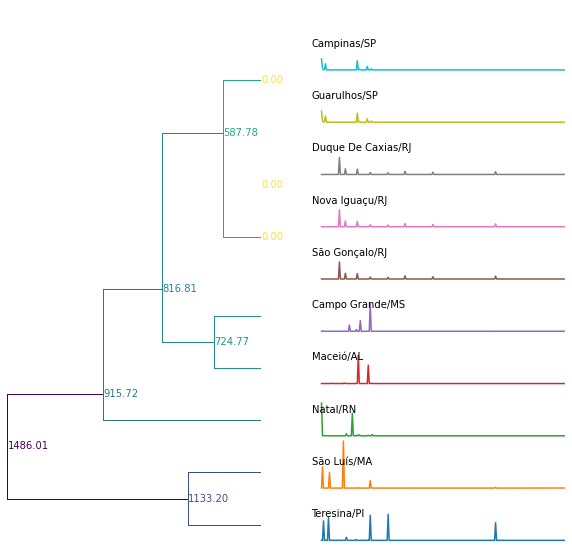

In [424]:
anestesico_model, anestesico_cluster_idx = get_clustering_model(timeseries)

## Dist. de EPI e Insumos

 90%|█████████ | 9/10 [00:00<00:00, 2109.69it/s]


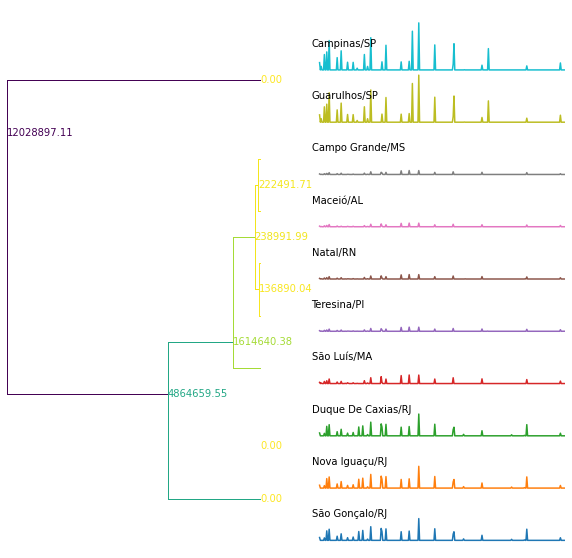

In [425]:
timeseries = get_timeseries(get_epi_dataset, ['cidade', 'uf_name'], 'DtSaida', 'Quantidade')
epi_model, epi_cluster_idx = get_clustering_model(timeseries)

## Dist. de Respiradores

 90%|█████████ | 9/10 [00:00<00:00, 2110.64it/s]


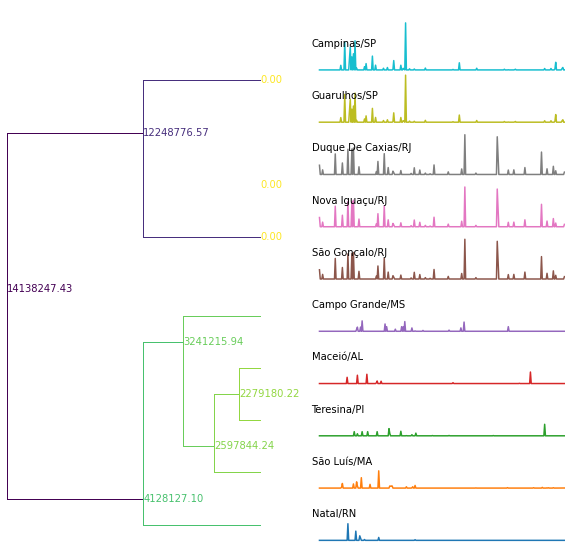

In [426]:
timeseries = get_timeseries(get_respirador_dataset, ['cidade', 'uf'], 'ENTREGA', 'VALOR')
respirador_model, respirador_cluster_idx = get_clustering_model(timeseries)

## Notificação de Síndrome Gripal

Duque de Caxias/RJ
Duque de Caxias/RJ: ../datasets/dados-rj-3.csv
Duque de Caxias/RJ: ../datasets/dados-rj-2.csv
Duque de Caxias/RJ: ../datasets/dados-rj-1.csv


b'Skipping line 344042: expected 29 fields, saw 31\n'
 90%|█████████ | 9/10 [00:00<00:00, 727.52it/s]


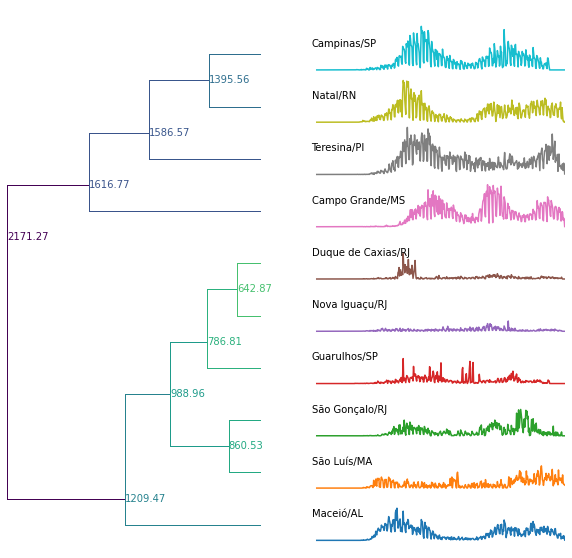

In [436]:
timeseries = get_timeseries(get_notificacao_dataset, ['cidade', 'uf'], 'date', 'value', apply=lambda df: df[df['resultadoTeste'] == 'Positivo'].copy())
notificacao_model, notificacao_cluster_idx = get_clustering_model(timeseries)

## Dist. de EPI e Insumos por Estado

In [456]:
estados = epi_df['Requisitante / Destino'].unique()
estados

array(['Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará',
       'Distrito Federal', 'Espírito Santo', 'Goiás', 'Maranhão',
       'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais',
       'Outros Órgãos Federais', 'Pará', 'Paraíba', 'Paraná',
       'Pernambuco', 'Piauí', 'Rio de Janeiro', 'Rio Grande do Norte',
       'Rio Grande do Sul', 'Rondônia', 'Roraima', 'Santa Catarina',
       'São Paulo', 'Sergipe', 'Tocantins'], dtype=object)

In [457]:
dfs = []
dates = []
x = 'DtSaida'
y = 'Quantidade'

for uf in estados:
    df = epi_df[epi_df['Requisitante / Destino'] == uf].copy()
    dates += [df[x].max(), df[x].min()]
    dfs.append(df[[x, y]].groupby([x]).sum())

idx = pd.date_range(min(dates), max(dates))
timeseries = []
for df in dfs:
    df = df.reindex(idx, fill_value=0)
    timeseries.append(df[y].to_numpy())

timeseries

[array([     0. ,      0. ,  31305.6,      0. ,   7800. ,      0. ,
             0. ,      0. ,  28488. ,      0. ,      0. ,  46117.2,
             0. ,      0. ,  87332. ,      0. ,      0. ,      0. ,
             0. ,      0. ,      0. ,      0. ,      0. ,      0. ,
         29032.6,      0. ,      0. ,      0. ,      0. ,  46975.5,
             0. ,      0. ,      0. ,      0. ,   3300. ,      0. ,
             0. ,  19998. ,   3300. ,      0. ,      0. ,      0. ,
             0. ,      0. ,  17238. ,      0. ,      0. ,      0. ,
             0. ,      0. ,      0. ,      0. ,      0. ,      0. ,
             0. ,      0. ,      0. ,      0. ,  57446. ,      0. ,
             0. ,      0. ,   7820. ,      0. ,      0. ,      0. ,
        107850. ,      0. ,      0. ,      0. ,      0. ,      0. ,
             0. ,      0. ,      0. ,      0. ,      0. ,      0. ,
             0. , 125800. ,  29600. ,      0. ,      0. ,      0. ,
             0. ,  91700. ,      0. ,      0. , 

 96%|█████████▋| 27/28 [00:00<00:00, 868.45it/s]


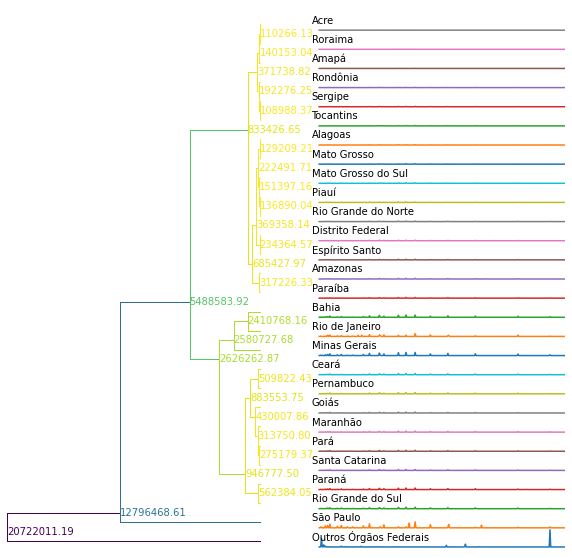

In [458]:
epi_estado_model, epi_estado_cluster_idx = get_clustering_model(timeseries, show_ts_label=lambda idx: estados[idx])